# Pixel2Mesh Sandbox

In [1]:
import os
import sys

os.chdir(os.path.join(os.getcwd(), '..'))

#### Outsourced Implementation

In [2]:
from core.models import P2MModel, P2MLoss, Ellipsoid

In [3]:
import os
import pprint
from argparse import ArgumentParser
from datetime import datetime

import numpy as np
import yaml
from easydict import EasyDict as edict

options = edict()

options.name = 'p2m'
options.version = None
options.num_workers = 1
options.num_gpus = 1
options.pin_memory = True

options.log_dir = "logs"
options.log_level = "info"
options.summary_dir = "summary"
options.checkpoint_dir = "checkpoints"
options.checkpoint = None

options.dataset = edict()
options.dataset.name = "shapenet"
options.dataset.subset_train = "train_small"
options.dataset.subset_eval = "test_small"
options.dataset.camera_f = [30., 30.]
options.dataset.camera_c = [112., 112.]
options.dataset.mesh_pos = [0., 0., -0.8]
options.dataset.normalization = True
options.dataset.num_classes = 13

options.dataset.shapenet = edict()
options.dataset.shapenet.num_points = 3000
options.dataset.shapenet.resize_with_constant_border = False

options.dataset.predict = edict()
options.dataset.predict.folder = "/tmp"

options.model = edict()
options.model.name = "pixel2mesh"
options.model.hidden_dim = 84
options.model.last_hidden_dim = 192
options.model.coord_dim = 3
options.model.backbone = "resnet50"
options.model.gconv_activation = True
# provide a boundary for z, so that z will never be equal to 0, on denominator
# if z is greater than 0, it will never be less than z;
# if z is less than 0, it will never be greater than z.
options.model.z_threshold = 1e-3
# align with original tensorflow model
# please follow experiments/tensorflow.yml
options.model.align_with_tensorflow = False

options.loss = edict()
options.loss.weights = edict()
options.loss.weights.normal = 1.6e-4
options.loss.weights.edge = 0.3
options.loss.weights.laplace = 0.5
options.loss.weights.move = 0.1
options.loss.weights.constant = 1.
options.loss.weights.chamfer = [1., 1., 1.]
options.loss.weights.chamfer_opposite = 1.
options.loss.weights.reconst = 0.

options.train = edict()
options.train.num_epochs = 50
options.train.batch_size = 4
options.train.summary_steps = 50
options.train.checkpoint_steps = 10000
options.train.test_epochs = 1
options.train.use_augmentation = True
options.train.shuffle = True

options.test = edict()
options.test.dataset = []
options.test.summary_steps = 50
options.test.batch_size = 4
options.test.shuffle = False
options.test.weighted_mean = False

options.optim = edict()
options.optim.name = "adam"
options.optim.adam_beta1 = 0.9
options.optim.sgd_momentum = 0.9
options.optim.lr = 5.0E-5
options.optim.wd = 1.0E-6
options.optim.lr_step = [30, 45]
options.optim.lr_factor = 0.1

##### Calculating Camera Intrinsics

In [4]:
# Calculating the focal length (camera_f) based on the field of view (FOV)
import math

image_height, image_width = 224, 224
view_angle = 30.0

f_y = (image_height/2) / math.tan(math.radians(view_angle/2))

# for a square image & symmetric FOV, f_x = f_y
f_x = f_y

camera_f = [f_x, f_y]
camera_c = [image_width/2, image_height/2]  # [512, 512]

##### Setup & Training

In [5]:
ell = Ellipsoid(a=15.0, b=15.0, c=15.0, base_subdivisions=2)

In [6]:
import torch
from torch.utils.data import DataLoader
import torchvision
from torch.utils.data import Subset

from data import PollenDataset

# 1) device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Using device:", device)

# 2) data  
def repeat_to_3channels(x):
    return x.repeat(3, 1, 1)

dataset = PollenDataset(
    image_transforms = torchvision.transforms.Compose([
        torchvision.transforms.Resize((224, 224)),
        torchvision.transforms.ToTensor(),                 # (1,H,W)
        torchvision.transforms.Lambda(lambda x: x.repeat(3,1,1)),  # (3,H,W)
        torchvision.transforms.Normalize([0.485, 0.456, 0.406],
                                        [0.229, 0.224, 0.225]),
    ])

)
dataset_subset = Subset(dataset, range(12))

loader = DataLoader(dataset_subset, batch_size=4, shuffle=True, num_workers=0)

# 3) model, loss, optimizer
model = P2MModel(
    options=options.model,
    ellipsoid=ell,
    camera_f=torch.tensor(camera_f, device=device),
    camera_c=torch.tensor(camera_c),
    mesh_pos=torch.tensor([0.0,0.0,0.0], device=device),
).to(device)

#for m in model.nn_encoder.modules():
#    if isinstance(m, nn.BatchNorm2d):
#        m.eval()           # freeze running stats
#        for p in m.parameters():
#            p.requires_grad = False   # optional: also freeze γ, β

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

loss_fn = P2MLoss(options.loss, ell)

Using device: cuda


In [7]:
# 4) simple train loop
best_loss = np.inf
num_epochs = 1000
for epoch in range(1, num_epochs+1):
    model.train()
    epoch_loss = 0.0

    for batch in loader:
        # unpack your dataset’s tuple:
        #  batch[0] = (left, right)
        #  batch[1] = (points, normals)
        #  batch[2] = rotations (ignored)
        #  batch[3] = voxels    (ignored)
        (left, _), (points, normals), _, _ = batch

        # move and reshape
        # left: (B,1,224,224) → repeat to 3 channels
        imgs   = left.to(device)
        points = points.to(device)    # (B, N_gt, 3)
        normals= normals.to(device)   # (B, N_gt, 3)

        targets = {
            "points":  points,
            "normals": normals,
            "images":  imgs,
        }

        optimizer.zero_grad()
        outputs = model(imgs)                    
        loss, summary = loss_fn(outputs, targets)
        
        loss.backward()
                                  
        optimizer.step()
        
        epoch_loss += loss.item()

    avg = epoch_loss / len(loader)
    if avg < best_loss:
        best_loss = avg
        # save model checkpoint
        torch.save(model.state_dict(), os.path.join('notebooks/p2m', "lowest_p2m_loss.pth"))
        print(f"Saved model with loss {best_loss:.4f} at epoch {epoch}")
    print(f"Epoch {epoch}/{num_epochs}  —  avg loss: {avg:.7f}")


Saved model with loss 4.2055 at epoch 1
Epoch 1/1000  —  avg loss: 4.2054738
Saved model with loss 3.6052 at epoch 2
Epoch 2/1000  —  avg loss: 3.6052334
Saved model with loss 3.3015 at epoch 3
Epoch 3/1000  —  avg loss: 3.3015345
Saved model with loss 3.1932 at epoch 4
Epoch 4/1000  —  avg loss: 3.1931730
Saved model with loss 3.1303 at epoch 5
Epoch 5/1000  —  avg loss: 3.1303124
Saved model with loss 3.0839 at epoch 6
Epoch 6/1000  —  avg loss: 3.0839329
Saved model with loss 3.0694 at epoch 7
Epoch 7/1000  —  avg loss: 3.0694083
Saved model with loss 3.0484 at epoch 8
Epoch 8/1000  —  avg loss: 3.0484460
Saved model with loss 3.0196 at epoch 9
Epoch 9/1000  —  avg loss: 3.0196028
Epoch 10/1000  —  avg loss: 3.0576121
Epoch 11/1000  —  avg loss: 3.0212484
Saved model with loss 2.9935 at epoch 12
Epoch 12/1000  —  avg loss: 2.9935412
Saved model with loss 2.9755 at epoch 13
Epoch 13/1000  —  avg loss: 2.9755092
Saved model with loss 2.9740 at epoch 14
Epoch 14/1000  —  avg loss: 2.97

In [8]:
model.load_state_dict(torch.load(os.path.join('notebooks/p2m', "lowest_p2m_loss.pth")))
model.eval()


P2MModel(
  (nn_encoder): P2MResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
   

In [55]:
sample_number = 3

# imgs: [4,3,224,224] batch
out = model(imgs)
# out['pred_coord'] is a list [x1, x2, x3], each shape [B, V, 3]
final_verts = out['pred_coord'][-1]                    # [B, V, 3]
final_verts = final_verts.detach().cpu().numpy()       # numpy

verts = final_verts[sample_number]    # (V,3)
faces = ell.faces[2]      # numpy array (F,3) of int indices

In [56]:
import trimesh

mesh = trimesh.Trimesh(vertices=verts, faces=faces, process=False)
mesh.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


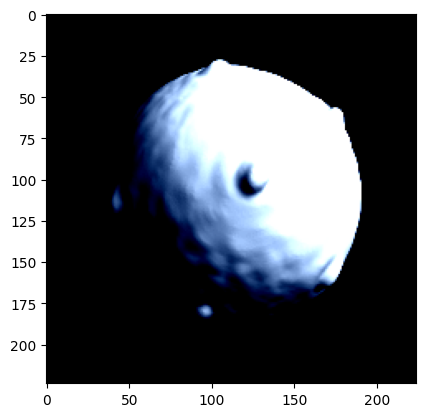

In [57]:
from matplotlib import pyplot as plt

plt.imshow(imgs[3].cpu().permute(1,2,0).numpy())

#### In Notebook Implementation

In [2]:
# https://arxiv.org/pdf/1804.01654v2
# p2m model init needs camera focal length, camera center and mesh center

In [3]:
import math

import torch
import torch.nn as nn

def batch_mm(matrix, batch):
    """
    https://github.com/pytorch/pytorch/issues/14489
    """
    # TODO: accelerate this with batch operations
    return torch.stack([matrix.mm(b) for b in batch], dim=0)


def dot(x, y, sparse=False):
    """Wrapper for torch.matmul (sparse vs dense)."""
    if sparse:
        return batch_mm(x, y)
    else:
        return torch.matmul(x, y)
    

class GConv(nn.Module):
    """Simple GCN layer

    Similar to https://arxiv.org/abs/1609.02907
    """

    def __init__(self, in_features, out_features, adj_mat, bias=True):
        super(GConv, self).__init__()
        self.in_features = in_features
        self.out_features = out_features

        self.adj_mat = nn.Parameter(adj_mat, requires_grad=False)
        self.weight = nn.Parameter(torch.zeros((in_features, out_features), dtype=torch.float))
        # Following https://github.com/Tong-ZHAO/Pixel2Mesh-Pytorch/blob/a0ae88c4a42eef6f8f253417b97df978db842708/model/gcn_layers.py#L45
        # This seems to be different from the original implementation of P2M
        self.loop_weight = nn.Parameter(torch.zeros((in_features, out_features), dtype=torch.float))
        if bias:
            self.bias = nn.Parameter(torch.zeros((out_features,), dtype=torch.float))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.weight.data)
        nn.init.xavier_uniform_(self.loop_weight.data)

    def forward(self, inputs):
        support = torch.matmul(inputs, self.weight)
        support_loop = torch.matmul(inputs, self.loop_weight)
        output = dot(self.adj_mat, support, True) + support_loop
        if self.bias is not None:
            ret = output + self.bias
        else:
            ret = output
        return ret

    def __repr__(self):
        return self.__class__.__name__ + ' (' \
               + str(self.in_features) + ' -> ' \
               + str(self.out_features) + ')'

In [4]:
import torch.nn as nn
import torch.nn.functional as F

class GResBlock(nn.Module):

    def __init__(self, in_dim, hidden_dim, adj_mat, activation=None):
        super(GResBlock, self).__init__()

        self.conv1 = GConv(in_features=in_dim, out_features=hidden_dim, adj_mat=adj_mat)
        self.conv2 = GConv(in_features=hidden_dim, out_features=in_dim, adj_mat=adj_mat)
        self.activation = F.relu if activation else None

    def forward(self, inputs):
        x = self.conv1(inputs)
        if self.activation:
            x = self.activation(x)
        x = self.conv2(x)
        if self.activation:
            x = self.activation(x)

        return (inputs + x) * 0.5


class GBottleneck(nn.Module):

    def __init__(self, block_num, in_dim, hidden_dim, out_dim, adj_mat, activation=None):
        super(GBottleneck, self).__init__()

        resblock_layers = [GResBlock(in_dim=hidden_dim, hidden_dim=hidden_dim, adj_mat=adj_mat, activation=activation)
                           for _ in range(block_num)]
        self.blocks = nn.Sequential(*resblock_layers)
        self.conv1 = GConv(in_features=in_dim, out_features=hidden_dim, adj_mat=adj_mat)
        self.conv2 = GConv(in_features=hidden_dim, out_features=out_dim, adj_mat=adj_mat)
        self.activation = F.relu if activation else None

    def forward(self, inputs):
        x = self.conv1(inputs)
        if self.activation:
            x = self.activation(x)
        x_hidden = self.blocks(x)
        x_out = self.conv2(x_hidden)

        return x_out, x_hidden

In [5]:
import torch
from torchvision.models import ResNet
from torchvision.models.resnet import Bottleneck

PRETRAINED_WEIGHTS_PATH = './notebooks/p2m/resnet.pth'

class P2MResNet(ResNet):

    def __init__(self, *args, **kwargs):
        self.output_dim = 0
        super().__init__(*args, **kwargs)

    def _make_layer(self, block, planes, blocks, stride=1, dilate=False):
        res = super()._make_layer(block, planes, blocks, stride=stride, dilate=dilate)
        self.output_dim += self.inplanes
        return res

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        features = []
        x = self.layer1(x)
        features.append(x)
        x = self.layer2(x)
        features.append(x)
        x = self.layer3(x)
        features.append(x)
        x = self.layer4(x)
        features.append(x)

        return features

    @property
    def features_dim(self):
        return self.output_dim


def resnet50(backbone_ckpt: str, in_ch: int = 3):
    model = P2MResNet(Bottleneck, [3, 4, 6, 3])

    ckpt = torch.load(backbone_ckpt, map_location="cpu")
    state_dict = ckpt.get("model", ckpt.get("state_dict", ckpt))

    # strip common prefixes
    clean_dict = {}
    for k, v in state_dict.items():
        for prefix in ("module.", "backbone.", "model."):
            if k.startswith(prefix):
                k = k[len(prefix):]
        clean_dict[k] = v

    # -------- adapt first conv if we want 1-channel images --------
    if in_ch == 1:
        # find the key that ends with "conv1.weight"
        conv1_key = next(
            k for k in clean_dict.keys() if k.endswith("conv1.weight")
        )
        w = clean_dict[conv1_key]                # (64,3,7,7) typically
        clean_dict[conv1_key] = w.mean(1, keepdim=True)

        # replace layer in the model definition too
        model.conv1 = nn.Conv2d(
            1, 64, kernel_size=7, stride=2, padding=3, bias=False
        )

    # load what we have, ignore extras (fc.* etc.)
    model.load_state_dict(clean_dict, strict=False)
    return model


In [6]:
class VGG16TensorflowAlign(nn.Module):

    def __init__(self, n_classes_input=3):
        super(VGG16TensorflowAlign, self).__init__()

        self.features_dim = 960
        # this is to align with tensorflow padding (with stride)
        # https://bugxch.github.io/tf%E4%B8%AD%E7%9A%84padding%E6%96%B9%E5%BC%8FSAME%E5%92%8CVALID%E6%9C%89%E4%BB%80%E4%B9%88%E5%8C%BA%E5%88%AB/
        self.same_padding = nn.ZeroPad2d(1)
        self.tf_padding = nn.ZeroPad2d((0, 1, 0, 1))
        self.tf_padding_2 = nn.ZeroPad2d((1, 2, 1, 2))

        self.conv0_1 = nn.Conv2d(n_classes_input, 16, 3, stride=1, padding=0)
        self.conv0_2 = nn.Conv2d(16, 16, 3, stride=1, padding=0)

        self.conv1_1 = nn.Conv2d(16, 32, 3, stride=2, padding=0)  # 224 -> 112
        self.conv1_2 = nn.Conv2d(32, 32, 3, stride=1, padding=0)
        self.conv1_3 = nn.Conv2d(32, 32, 3, stride=1, padding=0)

        self.conv2_1 = nn.Conv2d(32, 64, 3, stride=2, padding=0)  # 112 -> 56
        self.conv2_2 = nn.Conv2d(64, 64, 3, stride=1, padding=0)
        self.conv2_3 = nn.Conv2d(64, 64, 3, stride=1, padding=0)

        self.conv3_1 = nn.Conv2d(64, 128, 3, stride=2, padding=0)  # 56 -> 28
        self.conv3_2 = nn.Conv2d(128, 128, 3, stride=1, padding=0)
        self.conv3_3 = nn.Conv2d(128, 128, 3, stride=1, padding=0)

        self.conv4_1 = nn.Conv2d(128, 256, 5, stride=2, padding=0)  # 28 -> 14
        self.conv4_2 = nn.Conv2d(256, 256, 3, stride=1, padding=0)
        self.conv4_3 = nn.Conv2d(256, 256, 3, stride=1, padding=0)

        self.conv5_1 = nn.Conv2d(256, 512, 5, stride=2, padding=0)  # 14 -> 7
        self.conv5_2 = nn.Conv2d(512, 512, 3, stride=1, padding=0)
        self.conv5_3 = nn.Conv2d(512, 512, 3, stride=1, padding=0)
        self.conv5_4 = nn.Conv2d(512, 512, 3, stride=1, padding=0)

    def forward(self, img):
        img = F.relu(self.conv0_1(self.same_padding(img)))
        img = F.relu(self.conv0_2(self.same_padding(img)))

        img = F.relu(self.conv1_1(self.tf_padding(img)))
        img = F.relu(self.conv1_2(self.same_padding(img)))
        img = F.relu(self.conv1_3(self.same_padding(img)))

        img = F.relu(self.conv2_1(self.tf_padding(img)))
        img = F.relu(self.conv2_2(self.same_padding(img)))
        img = F.relu(self.conv2_3(self.same_padding(img)))
        img2 = img

        img = F.relu(self.conv3_1(self.tf_padding(img)))
        img = F.relu(self.conv3_2(self.same_padding(img)))
        img = F.relu(self.conv3_3(self.same_padding(img)))
        img3 = img

        img = F.relu(self.conv4_1(self.tf_padding_2(img)))
        img = F.relu(self.conv4_2(self.same_padding(img)))
        img = F.relu(self.conv4_3(self.same_padding(img)))
        img4 = img

        img = F.relu(self.conv5_1(self.tf_padding_2(img)))
        img = F.relu(self.conv5_2(self.same_padding(img)))
        img = F.relu(self.conv5_3(self.same_padding(img)))
        img = F.relu(self.conv5_4(self.same_padding(img)))
        img5 = img

        return [img2, img3, img4, img5]


class VGG16P2M(nn.Module):

    def __init__(self, n_classes_input=3, pretrained=False):
        super(VGG16P2M, self).__init__()

        self.features_dim = 960

        self.conv0_1 = nn.Conv2d(n_classes_input, 16, 3, stride=1, padding=1)
        self.conv0_2 = nn.Conv2d(16, 16, 3, stride=1, padding=1)

        self.conv1_1 = nn.Conv2d(16, 32, 3, stride=2, padding=1)  # 224 -> 112
        self.conv1_2 = nn.Conv2d(32, 32, 3, stride=1, padding=1)
        self.conv1_3 = nn.Conv2d(32, 32, 3, stride=1, padding=1)

        self.conv2_1 = nn.Conv2d(32, 64, 3, stride=2, padding=1)  # 112 -> 56
        self.conv2_2 = nn.Conv2d(64, 64, 3, stride=1, padding=1)
        self.conv2_3 = nn.Conv2d(64, 64, 3, stride=1, padding=1)

        self.conv3_1 = nn.Conv2d(64, 128, 3, stride=2, padding=1)  # 56 -> 28
        self.conv3_2 = nn.Conv2d(128, 128, 3, stride=1, padding=1)
        self.conv3_3 = nn.Conv2d(128, 128, 3, stride=1, padding=1)

        self.conv4_1 = nn.Conv2d(128, 256, 5, stride=2, padding=2)  # 28 -> 14
        self.conv4_2 = nn.Conv2d(256, 256, 3, stride=1, padding=1)
        self.conv4_3 = nn.Conv2d(256, 256, 3, stride=1, padding=1)

        self.conv5_1 = nn.Conv2d(256, 512, 5, stride=2, padding=2)  # 14 -> 7
        self.conv5_2 = nn.Conv2d(512, 512, 3, stride=1, padding=1)
        self.conv5_3 = nn.Conv2d(512, 512, 3, stride=1, padding=1)
        self.conv5_4 = nn.Conv2d(512, 512, 3, stride=1, padding=1)

        if "vgg16p2m" in PRETRAINED_WEIGHTS_PATH and pretrained:
            state_dict = torch.load(PRETRAINED_WEIGHTS_PATH)
            self.load_state_dict(state_dict)
        else:
            self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, img):
        img = F.relu(self.conv0_1(img))
        img = F.relu(self.conv0_2(img))
        # img0 = torch.squeeze(img) # 224

        img = F.relu(self.conv1_1(img))
        img = F.relu(self.conv1_2(img))
        img = F.relu(self.conv1_3(img))
        # img1 = torch.squeeze(img) # 112

        img = F.relu(self.conv2_1(img))
        img = F.relu(self.conv2_2(img))
        img = F.relu(self.conv2_3(img))
        img2 = img

        img = F.relu(self.conv3_1(img))
        img = F.relu(self.conv3_2(img))
        img = F.relu(self.conv3_3(img))
        img3 = img

        img = F.relu(self.conv4_1(img))
        img = F.relu(self.conv4_2(img))
        img = F.relu(self.conv4_3(img))
        img4 = img

        img = F.relu(self.conv5_1(img))
        img = F.relu(self.conv5_2(img))
        img = F.relu(self.conv5_3(img))
        img = F.relu(self.conv5_4(img))
        img5 = img

        return [img2, img3, img4, img5]


class VGG16Recons(nn.Module):

    def __init__(self, input_dim=512, image_channel=3):
        super(VGG16Recons, self).__init__()

        self.conv_1 = nn.ConvTranspose2d(input_dim, 256, kernel_size=2, stride=2, padding=0)  # 7 -> 14
        self.conv_2 = nn.ConvTranspose2d(512, 128, kernel_size=4, stride=2, padding=1)  # 14 -> 28
        self.conv_3 = nn.ConvTranspose2d(256, 64, kernel_size=4, stride=2, padding=1)  # 28 -> 56
        self.conv_4 = nn.ConvTranspose2d(128, 32, kernel_size=6, stride=2, padding=2)  # 56 -> 112
        self.conv_5 = nn.ConvTranspose2d(32, image_channel, kernel_size=6, stride=2, padding=2)  # 112 -> 224

    def forward(self, img_feats):
        x = F.relu(self.conv_1(img_feats[-1]))
        x = torch.cat((x, img_feats[-2]), dim=1)
        x = F.relu(self.conv_2(x))
        x = torch.cat((x, img_feats[-3]), dim=1)
        x = F.relu(self.conv_3(x))
        x = torch.cat((x, img_feats[-4]), dim=1)
        x = F.relu(self.conv_4(x))
        x = F.relu(self.conv_5(x))

        return torch.sigmoid(x)

In [7]:
def get_backbone(options):
    if options.backbone.startswith("vgg16"):
        if options.align_with_tensorflow:
            nn_encoder = VGG16TensorflowAlign(n_classes_input=1)
        else:
            nn_encoder = VGG16P2M(pretrained="pretrained" in options.backbone, n_classes_input=1)
        nn_decoder = VGG16Recons()
    elif options.backbone == "resnet50":
        nn_encoder = resnet50(backbone_ckpt=PRETRAINED_WEIGHTS_PATH, in_ch=3)
        nn_decoder = None
    else:
        raise NotImplementedError("No implemented backbone called '%s' found" % options.backbone)
    return nn_encoder, nn_decoder

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class GUnpooling(nn.Module):
    """Graph Pooling layer, aims to add additional vertices to the graph.
    The middle point of each edges are added, and its feature is simply
    the average of the two edge vertices.
    Three middle points are connected in each triangle.
    """

    def __init__(self, unpool_idx):
        super(GUnpooling, self).__init__()
        self.unpool_idx = unpool_idx
        # save dim info
        self.in_num = torch.max(unpool_idx).item()
        self.out_num = self.in_num + len(unpool_idx)

    def forward(self, inputs):
        new_features = inputs[:, self.unpool_idx].clone()
        new_vertices = 0.5 * new_features.sum(2)
        output = torch.cat([inputs, new_vertices], 1)

        return output

    def __repr__(self):
        return self.__class__.__name__ + ' (' \
               + str(self.in_num) + ' -> ' \
               + str(self.out_num) + ')'

import numpy as np
from torch.nn import Threshold

class GProjection(nn.Module):
    """
    Graph Projection layer, which pool 2D features to mesh

    The layer projects a vertex of the mesh to the 2D image and use
    bi-linear interpolation to get the corresponding feature.
    """

    def __init__(self, mesh_pos, camera_f, camera_c, bound=0, tensorflow_compatible=False):
        super(GProjection, self).__init__()
        self.mesh_pos, self.camera_f, self.camera_c = mesh_pos, camera_f, camera_c
        self.threshold = None
        self.bound = float(bound)
        self.tensorflow_compatible = tensorflow_compatible
        if self.bound != 0:
            self.threshold = Threshold(abs(self.bound), abs(self.bound))

    def bound_val(self, x):
        """
        given x, return min(threshold, x), in case threshold is not None
        """
        if self.bound < 0:
            return -self.threshold(-x)
        elif self.bound > 0:
            return self.threshold(x)
        return x

    @staticmethod
    def image_feature_shape(img):
        return np.array([img.size(-1), img.size(-2)])

    def project_tensorflow(self, x, y, img_size, img_feat):
        x = torch.clamp(x, min=0, max=img_size[1] - 1)
        y = torch.clamp(y, min=0, max=img_size[0] - 1)

        # it's tedious and contains bugs...
        # when x1 = x2, the area is 0, therefore it won't be processed
        # keep it here to align with tensorflow version
        x1, x2 = torch.floor(x).long(), torch.ceil(x).long()
        y1, y2 = torch.floor(y).long(), torch.ceil(y).long()

        Q11 = img_feat[:, x1, y1].clone()
        Q12 = img_feat[:, x1, y2].clone()
        Q21 = img_feat[:, x2, y1].clone()
        Q22 = img_feat[:, x2, y2].clone()

        weights = torch.mul(x2.float() - x, y2.float() - y)
        Q11 = torch.mul(weights.unsqueeze(-1), torch.transpose(Q11, 0, 1))

        weights = torch.mul(x2.float() - x, y - y1.float())
        Q12 = torch.mul(weights.unsqueeze(-1), torch.transpose(Q12, 0, 1))

        weights = torch.mul(x - x1.float(), y2.float() - y)
        Q21 = torch.mul(weights.unsqueeze(-1), torch.transpose(Q21, 0, 1))

        weights = torch.mul(x - x1.float(), y - y1.float())
        Q22 = torch.mul(weights.unsqueeze(-1), torch.transpose(Q22, 0, 1))

        output = Q11 + Q21 + Q12 + Q22
        return output

    def forward(self, resolution, img_features, inputs):
        half_resolution = (resolution - 1) / 2
        camera_c_offset = np.asarray(self.camera_c, dtype=np.float32) - half_resolution
        # map to [-1, 1]
        # not sure why they render to negative x
        positions = inputs + self.mesh_pos
        w = -self.camera_f[0] * (positions[:, :, 0] / self.bound_val(positions[:, :, 2])) + camera_c_offset[0]
        h = self.camera_f[1] * (positions[:, :, 1] / self.bound_val(positions[:, :, 2])) + camera_c_offset[1]

        if self.tensorflow_compatible:
            # to align with tensorflow
            # this is incorrect, I believe
            w += half_resolution[0]
            h += half_resolution[1]

        else:
            # directly do clamping
            w /= half_resolution[0]
            h /= half_resolution[1]

            # clamp to [-1, 1]
            w = torch.clamp(w, min=-1, max=1)
            h = torch.clamp(h, min=-1, max=1)

        feats = [inputs]
        for img_feature in img_features:
            feats.append(self.project(resolution, img_feature, torch.stack([w, h], dim=-1)))

        output = torch.cat(feats, 2)

        return output

    def project(self, img_shape, img_feat, sample_points):
        """
        :param img_shape: raw image shape
        :param img_feat: [batch_size x channel x h x w]
        :param sample_points: [batch_size x num_points x 2], in range [-1, 1]
        :return: [batch_size x num_points x feat_dim]
        """
        if self.tensorflow_compatible:
            feature_shape = self.image_feature_shape(img_feat)
            points_w = sample_points[:, :, 0] / (img_shape[0] / feature_shape[0])
            points_h = sample_points[:, :, 1] / (img_shape[1] / feature_shape[1])
            output = torch.stack([self.project_tensorflow(points_h[i], points_w[i],
                                                          feature_shape, img_feat[i]) for i in range(img_feat.size(0))], 0)
        else:
            output = F.grid_sample(img_feat, sample_points.unsqueeze(1), align_corners=False)
            output = torch.transpose(output.squeeze(2), 1, 2)

        return output

class P2MModel(nn.Module):

    def __init__(self, options, ellipsoid, camera_f, camera_c, mesh_pos):
        super(P2MModel, self).__init__()

        self.hidden_dim = options.hidden_dim
        self.coord_dim = options.coord_dim
        self.last_hidden_dim = options.last_hidden_dim
        self.init_pts = nn.Parameter(ellipsoid.coord, requires_grad=False)
        self.gconv_activation = options.gconv_activation

        self.nn_encoder, self.nn_decoder = get_backbone(options)
        self.features_dim = self.nn_encoder.features_dim + self.coord_dim

        self.gcns = nn.ModuleList([
            GBottleneck(6, self.features_dim, self.hidden_dim, self.coord_dim,
                        ellipsoid.adj_mat[0], activation=True),
            GBottleneck(6, self.features_dim + self.hidden_dim, self.hidden_dim, self.coord_dim,
                        ellipsoid.adj_mat[1], activation=True),
            GBottleneck(6, self.features_dim + self.hidden_dim, self.hidden_dim, self.last_hidden_dim,
                        ellipsoid.adj_mat[2], activation=True)
        ])

        self.unpooling = nn.ModuleList([
            GUnpooling(ellipsoid.unpool_idx[0]),
            GUnpooling(ellipsoid.unpool_idx[1])
        ])

        # if options.align_with_tensorflow:
        #     self.projection = GProjection
        # else:
        #     self.projection = GProjection
        self.projection = GProjection(mesh_pos, camera_f, camera_c, bound=options.z_threshold,
                                      tensorflow_compatible=options.align_with_tensorflow)

        self.gconv = GConv(in_features=self.last_hidden_dim, out_features=self.coord_dim,
                           adj_mat=ellipsoid.adj_mat[2])

    def _apply_offset(self, base, delta, scale=0.1):
        """Pixel2Mesh style vertex update"""
        return base + scale * delta          # scale is the ‘σ’ in the paper (≈0.1)
    
    def forward(self, img):
        batch_size = img.size(0)
        img_feats = self.nn_encoder(img)
        img_shape = self.projection.image_feature_shape(img)

        init_pts = self.init_pts.data.unsqueeze(0).expand(batch_size, -1, -1)
        # GCN Block 1
        x = self.projection(img_shape, img_feats, init_pts)
        x1, x_hidden = self.gcns[0](x)

        # before deformation 2
        x1_up = self.unpooling[0](x1)

        # GCN Block 2
        x = self.projection(img_shape, img_feats, x1)
        x = self.unpooling[0](torch.cat([x, x_hidden], 2))
        # after deformation 2
        x2, x_hidden = self.gcns[1](x)

        # before deformation 3
        x2_up = self.unpooling[1](x2)

        # GCN Block 3
        x = self.projection(img_shape, img_feats, x2)
        x = self.unpooling[1](torch.cat([x, x_hidden], 2))
        x3, _ = self.gcns[2](x)
        if self.gconv_activation:
            x3 = F.relu(x3)
        # after deformation 3
        x3 = self.gconv(x3)

        if self.nn_decoder is not None:
            reconst = self.nn_decoder(img_feats)
        else:
            reconst = None

        return {
            "pred_coord": [x1, x2, x3],
            "pred_coord_before_deform": [init_pts, x1_up, x2_up],
            "reconst": reconst
        }


In [9]:
import torch
import numpy as np
import trimesh
from typing import List, Tuple

def _unique_edges(faces: np.ndarray) -> np.ndarray:
    # faces: (F,3)
    e01 = faces[:, [0, 1]]
    e12 = faces[:, [1, 2]]
    e20 = faces[:, [2, 0]]
    all_e = np.vstack([e01, e12, e20])
    all_e.sort(axis=1)   # undirected
    return np.unique(all_e, axis=0)

def normalise_adj(edge_index, num_nodes):
    """Return D⁻¹Â with self-loops (PyTorch sparse COO)."""
    row, col = edge_index
    self_loop = torch.arange(num_nodes, device=row.device)
    row = torch.cat([row, self_loop])
    col = torch.cat([col, self_loop])
    val = torch.ones_like(row, dtype=torch.float32)

    deg = torch.bincount(row, minlength=num_nodes).clamp(min=1)
    val = val / deg[row]                       # row-wise D⁻¹Â
    idx = torch.stack([row, col])
    return torch.sparse_coo_tensor(idx, val, (num_nodes, num_nodes))

class Ellipsoid:
    def __init__(
        self,
        a: float = 1.0,
        b: float = 1.0,
        c: float = 1.0,
        base_subdivisions: int = 3,
        lap_k: int = 10,
    ):
        """
        Builds three levels of icosphere meshes (subdivisions = base_subdivisions,
        +1 and +2), scales them by (a,b,c), and then:
          - coord           : (V0, 3)  coarse vertices
          - faces[i]        : (Fi,3)   triangle indices at level i
          - edges[i]        : (Ei,2)   unique undirected edges at level i
          - laplace_idx[i]  : (Vi, lap_k) neighbor indices padded with -1
          - adj_mat[i]      : sparse COO (Vi × Vi)
          - unpool_idx      : [edges_coarse, edges_mid]
        """
        # 1) create & scale meshes
        meshes = []
        for s in [base_subdivisions, base_subdivisions + 1, base_subdivisions + 2]:
            m = trimesh.creation.icosphere(subdivisions=s, radius=1.0)
            m.apply_scale([a, b, c])
            meshes.append(m)

        # 2) extract verts & faces as torch
        verts: List[torch.Tensor] = [
            torch.from_numpy(m.vertices).float() for m in meshes
        ]
        faces: List[torch.Tensor] = [
            torch.from_numpy(m.faces.astype(np.int64)).long() for m in meshes
        ]
        self.coord = verts[0]   # coarse points for init_pts
        self.faces = faces      # three levels

        self.edges: List[torch.Tensor] = []
        self.laplace_idx: List[torch.Tensor] = []
        self.adj_mat: List[torch.sparse_coo_tensor] = []

        # 3) for each level build edges, laplacian‐index, adj_mat
        for i, (v, f) in enumerate(zip(verts, faces)):
            V = v.shape[0]

            # 3a) edges
            ue = _unique_edges(f.numpy())            # (Ei,2) as np
            e_t = torch.from_numpy(ue).long()         # to torch
            self.edges.append(e_t)

            # 3b) laplace_idx (k-NN padding)
            nbrs = [[] for _ in range(V)]
            for u, w in ue:
                nbrs[u].append(int(w))
                nbrs[w].append(int(u))

            # --- inside Ellipsoid.__init__ after building nbrs -----------
            laplace = torch.full((V, lap_k+1), -1, dtype=torch.long)
            for vidx, neigh in enumerate(nbrs):
                k = min(len(neigh), lap_k)
                laplace[vidx, :k] = torch.tensor(neigh[:k])
                laplace[vidx, -1] = k                     # <-- neighbour count
            self.laplace_idx.append(laplace)
            
            # 3c) adjacency sparse COO
            rows = []
            cols = []
            for u, w in ue:
                rows += [u, w]
                cols += [w, u]
            
            idx  = torch.tensor([rows, cols], dtype=torch.long)        # (2, E·2)
            A    = normalise_adj(idx, V)                               # D⁻¹Â with self-loops
            self.adj_mat.append(A)

        # 4) unpool: coarse→mid and mid→fine
        #    simply “every edge spawns a midpoint”
        self.unpool_idx = [
            self.edges[0],   # shape (E0,2)
            self.edges[1],   # shape (E1,2)
        ]

    def __repr__(self):
        vs = [v.shape[0] for v in self.laplace_idx]
        es = [e.shape[0] for e in self.edges]
        fs = [f.shape[0] for f in self.faces]
        return (
            f"<Ellipsoid: "
            f"levels V={vs}, E={es}, F={fs}>"
        )


In [10]:
import pickle
import trimesh
import torch

ell = Ellipsoid(a=15.0, b=15.0, c=15.0, base_subdivisions=2)

In [11]:
trimesh.Trimesh(
    vertices=ell.coord.numpy(),
    faces=ell.faces[0].numpy(),
).show()


# save ellipsoid as stl
ellipsoid = trimesh.Trimesh(
    vertices=ell.coord.numpy(),
    faces=ell.faces[0].numpy(),
)
ellipsoid.export('notebooks/p2m/ellipsoid.stl')

b'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00@\x01\x00\x00\xac\r\x10\xbf\x85\x8dO?\x9e<%>\xd7Y\xfc\xc0\xfc\'LA\x00\x00\x00\x00\xdf\x81&\xc1\xbc}(Ay2\x1a@:D\xd0\xc0Z\nOA\t\x7fy@\x00\x00?\xa34\xbf\x0ce"?\x87\xaa\xa1>\xdf\x81&\xc1\xbc}(Ay2\x1a@\x01*B\xc1\x00\x00\xf0@\x02T\x94@\x87\x11\r\xc1t*%A\xfc\'\xcc@\x00\x00\xf9\xf3\xe7\xbe\x86[J?\x18\x10\xd3>:D\xd0\xc0Z\nOA\t\x7fy@\x87\x11\r\xc1t*%A\xfc\'\xcc@\x02T\x94\xc0\x01*BA\x00\x00\xf0@\x00\x00\x916\x14\xbf\xcc\xc4D?\x10L\x8b>\xdf\x81&\xc1\xbc}(Ay2\x1a@\x87\x11\r\xc1t*%A\xfc\'\xcc@:D\xd0\xc0Z\nOA\t\x7fy@\x00\x00\x86[J\xbf\x18\x10\xd3>\xf9\xf3\xe7>\x01*B\xc1\x00\x00\xf0@\x02T\x94@Z\nO\xc1\t\x7fy@:D\xd0@t*%\xc1\xfc\'\xcc@\x87\x11\rA\x00\x00\x85\x8dO\xbf\x9e<%>\xac\r\x10?Z\n

In [12]:
import os
import pprint
from argparse import ArgumentParser
from datetime import datetime

import numpy as np
import yaml
from easydict import EasyDict as edict

options = edict()

options.name = 'p2m'
options.version = None
options.num_workers = 1
options.num_gpus = 1
options.pin_memory = True

options.log_dir = "logs"
options.log_level = "info"
options.summary_dir = "summary"
options.checkpoint_dir = "checkpoints"
options.checkpoint = None

options.dataset = edict()
options.dataset.name = "shapenet"
options.dataset.subset_train = "train_small"
options.dataset.subset_eval = "test_small"
options.dataset.camera_f = [30., 30.]
options.dataset.camera_c = [112., 112.]
options.dataset.mesh_pos = [0., 0., -0.8]
options.dataset.normalization = True
options.dataset.num_classes = 13

options.dataset.shapenet = edict()
options.dataset.shapenet.num_points = 3000
options.dataset.shapenet.resize_with_constant_border = False

options.dataset.predict = edict()
options.dataset.predict.folder = "/tmp"

options.model = edict()
options.model.name = "pixel2mesh"
options.model.hidden_dim = 192
options.model.last_hidden_dim = 192
options.model.coord_dim = 3
options.model.backbone = "resnet50"
options.model.gconv_activation = True
# provide a boundary for z, so that z will never be equal to 0, on denominator
# if z is greater than 0, it will never be less than z;
# if z is less than 0, it will never be greater than z.
options.model.z_threshold = 1e-3
# align with original tensorflow model
# please follow experiments/tensorflow.yml
options.model.align_with_tensorflow = False

options.loss = edict()
options.loss.weights = edict()
options.loss.weights.normal = 1.6e-4
options.loss.weights.edge = 0.3
options.loss.weights.laplace = 0.5
options.loss.weights.move = 0.1
options.loss.weights.constant = 1.
options.loss.weights.chamfer = [1., 1., 1.]
options.loss.weights.chamfer_opposite = 1.
options.loss.weights.reconst = 0.

options.train = edict()
options.train.num_epochs = 50
options.train.batch_size = 4
options.train.summary_steps = 50
options.train.checkpoint_steps = 10000
options.train.test_epochs = 1
options.train.use_augmentation = True
options.train.shuffle = True

options.test = edict()
options.test.dataset = []
options.test.summary_steps = 50
options.test.batch_size = 4
options.test.shuffle = False
options.test.weighted_mean = False

options.optim = edict()
options.optim.name = "adam"
options.optim.adam_beta1 = 0.9
options.optim.sgd_momentum = 0.9
options.optim.lr = 5.0E-5
options.optim.wd = 1.0E-6
options.optim.lr_step = [30, 45]
options.optim.lr_factor = 0.1


In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from chamferdist.chamfer import knn_points

class P2MLoss(nn.Module):
    def __init__(self, options, ellipsoid):
        super().__init__()
        self.options = options

        self.l1_loss = nn.L1Loss(reduction='mean')
        self.l2_loss = nn.MSELoss(reduction='mean')

        # We use knn_points instead of ChamferDistance direct
        self.chamfer_dist = None

        # Store laplace indices and edge lists
        # They remain on CPU but will be moved at runtime
        self.laplace_idx = nn.ParameterList([
            nn.Parameter(idx, requires_grad=False)
            for idx in ellipsoid.laplace_idx
        ])
        self.edges = nn.ParameterList([
            nn.Parameter(e, requires_grad=False)
            for e in ellipsoid.edges
        ])

    def edge_regularization(self, pred, edges):
        # Move edges to pred's device
        if edges.device != pred.device:
            edges = edges.to(pred.device)
        return self.l2_loss(
            pred[:, edges[:, 0]],
            pred[:, edges[:, 1]]
        ) * pred.size(-1)

    @staticmethod
    def laplace_coord(inputs, lap_idx):
        # Move lap_idx to inputs device
        if lap_idx.device != inputs.device:
            lap_idx = lap_idx.to(inputs.device)

        indices = lap_idx[:, :-2]
        invalid_mask = indices < 0
        all_valid = indices.clone()
        all_valid[invalid_mask] = 0

        neighs = inputs[:, all_valid]
        neighs[:, invalid_mask] = 0
        nbr_sum = neighs.sum(dim=2)
        nbr_cnt = lap_idx[:, -1].float()

        return inputs - nbr_sum / nbr_cnt[None, :, None]

    def laplace_regularization(self, before, after, level):
        lap1 = self.laplace_coord(before, self.laplace_idx[level])
        lap2 = self.laplace_coord(after,  self.laplace_idx[level])
        lap_loss = self.l2_loss(lap1, lap2) * lap1.size(-1)
        move_loss = (
            self.l2_loss(before, after) * before.size(-1)
            if level > 0 else 0.0
        )
        return lap_loss, move_loss

    def normal_loss(self, gt_normals, idx2, pred_pts, edges):
        # Move edges and idx2 to pred_pts device
        if edges.device != pred_pts.device:
            edges = edges.to(pred_pts.device)
        if idx2.device != pred_pts.device:
            idx2 = idx2.to(pred_pts.device)

        e = F.normalize(
            pred_pts[:, edges[:, 0]] - pred_pts[:, edges[:, 1]],
            dim=2
        )
        nearest = torch.stack([
            normals[i] for normals, i in zip(gt_normals, idx2.long())
        ])
        n = F.normalize(nearest[:, edges[:, 0]], dim=2)
        cos = torch.abs((e * n).sum(dim=2))
        return cos.mean()

    def image_loss(self, gt_img, reconst):
        return F.binary_cross_entropy(reconst, gt_img)

    def forward(self, outputs, targets):
        gt_coord, gt_normals, gt_imgs = (
            targets['points'],
            targets['normals'],
            targets['images']
        )
        pred_list   = outputs['pred_coord']
        before_list = outputs['pred_coord_before_deform']
        lap_const   = [0.2, 1.0, 1.0]

        chamfer_loss = 0.0
        edge_loss    = 0.0
        normal_loss  = 0.0
        lap_loss     = 0.0
        move_loss    = 0.0

        # Reconstruction term
        img_loss = 0.0
        if outputs.get('reconst', None) is not None and self.options.weights.reconst != 0:
            img_loss = self.image_loss(gt_imgs, outputs['reconst'])

        for lvl in range(3):
            P = pred_list[lvl]
           

            # Chamfer via knn_points
            knn1 = knn_points(gt_coord, P, K=1)
            d1 = torch.sqrt(knn1.dists[...,0] + 1e-12)
            knn2 = knn_points(P, gt_coord, K=1)
            d2 = torch.sqrt(knn2.dists[..., 0] + 1e-12)
            idx2 = knn2.idx[...,   0]

            chamfer_loss += (
                self.options.weights.chamfer[lvl] *
                (d1.mean() + self.options.weights.chamfer_opposite * d2.mean())
            )

            normal_loss += self.normal_loss(
                gt_normals, idx2, P, self.edges[lvl]
            )

            edge_loss += self.edge_regularization(P, self.edges[lvl])

            lap, move = self.laplace_regularization(
                before_list[lvl], P, lvl
            )
            lap_loss  += lap_const[lvl] * lap
            move_loss += lap_const[lvl] * move

        loss = (
              chamfer_loss
            + img_loss     * self.options.weights.reconst
            + lap_loss     * self.options.weights.laplace
            + move_loss    * self.options.weights.move
            + edge_loss    * self.options.weights.edge
            + normal_loss  * self.options.weights.normal
        )
        loss = loss * self.options.weights.constant

        return loss, {
            'loss':        loss,
            'loss_chamfer':chamfer_loss,
            'loss_edge':   edge_loss,
            'loss_laplace':lap_loss,
            'loss_move':   move_loss,
            'loss_normal': normal_loss,
        }


In [14]:
model = P2MModel(
    options=options.model,
    ellipsoid=ell,
    camera_f=torch.tensor([30.0,30.0]),
    camera_c=torch.tensor([112.0,112.0]),
    mesh_pos=torch.tensor([0., 0., -0.8])
)

loss_fn = P2MLoss(options.loss, ell)

In [15]:
# Calculating the focal length (camera_f) based on the field of view (FOV)
import math

image_height, image_width = 224, 224
view_angle = 30.0

f_y = (image_height/2) / math.tan(math.radians(view_angle/2))

# for a square image & symmetric FOV, f_x = f_y
f_x = f_y

camera_f = [f_x, f_y]
camera_c = [image_width/2, image_height/2]  # [512, 512]


In [16]:
model = P2MModel(
    options=options.model,
    ellipsoid=ell,
    camera_f=torch.tensor(camera_f),
    camera_c=torch.tensor(camera_c),
    mesh_pos=torch.tensor([0.0, 0.0, -0.8])
)


In [17]:
from data import PollenDataset

In [18]:
import torchvision

dataset = PollenDataset(image_transforms=torchvision.transforms.Compose([
                                            torchvision.transforms.Resize((224, 224)),
                                            torchvision.transforms.ToTensor(),
                                        ]))

In [19]:
(left_tensor, right_tensor), (points, normals), rotations, voxels = dataset[1]

In [48]:
import torch
from torch.utils.data import DataLoader
import torchvision
from torch.utils.data import Subset

from data import PollenDataset

# 1) device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2) data  
def repeat_to_3channels(x):
    return x.repeat(3, 1, 1)

dataset = PollenDataset(
    image_transforms = torchvision.transforms.Compose([
        torchvision.transforms.Resize((224, 224)),
        torchvision.transforms.ToTensor(),                 # (1,H,W)
        torchvision.transforms.Lambda(lambda x: x.repeat(3,1,1)),  # (3,H,W)
        torchvision.transforms.Normalize([0.485, 0.456, 0.406],
                                        [0.229, 0.224, 0.225]),
    ])

)
dataset_subset = Subset(dataset, range(128))

loader = DataLoader(dataset_subset, batch_size=12, shuffle=True, num_workers=0)

# 3) model, loss, optimizer
model = P2MModel(
    options=options.model,
    ellipsoid=ell,
    camera_f=torch.tensor(camera_f, device=device),
    camera_c=torch.tensor(camera_c),
    mesh_pos=torch.tensor([0.0,0.0,0.0], device=device),
).to(device)

#for m in model.nn_encoder.modules():
#    if isinstance(m, nn.BatchNorm2d):
#        m.eval()           # freeze running stats
#        for p in m.parameters():
#            p.requires_grad = False   # optional: also freeze γ, β

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)


In [49]:
epoch_loss = 0.0
for i, batch in enumerate(loader):
    (left, _), (points, normals), _, _ = batch
    imgs   = left.to(device)
    points = points.to(device)    # (B, N_gt, 3)
    normals= normals.to(device)   # (B, N_gt, 3)

    targets = {
        "points":  points,
        "normals": normals,
        "images":  imgs,
    }

    outputs = model(imgs)                    
    loss, summary = loss_fn(outputs, targets)
    
    print(f"{i:03d}: loss {loss.item():.4f}   "
          f"dv1 {outputs['pred_coord'][0].sub(outputs['pred_coord_before_deform'][0]).abs().mean():.4f}")

    with torch.no_grad():
        v0  = outputs["pred_coord_before_deform"][0]   # (B,V0,3)
        v1  = outputs["pred_coord"][0]                 # (B,V0,3)
        diff= (v1 - v0).abs()                     # displacement magnitude

    print("v0  range:", v0.min().item(), v0.max().item())
    print("v1  range:", v1.min().item(), v1.max().item())
    print("|Δv| mean:", diff.mean().item())

    loss.backward()
    
    optimizer.step()
    optimizer.zero_grad()

    epoch_loss += loss.item()

000: loss 3.5517   dv1 7.5076
v0  range: -15.0 15.0
v1  range: -1.051584243774414 0.8823515772819519
|Δv| mean: 7.5076422691345215
001: loss 3.1416   dv1 7.5009
v0  range: -15.0 15.0
v1  range: -1.0600533485412598 1.2952979803085327
|Δv| mean: 7.500886917114258
002: loss 3.2314   dv1 7.5019
v0  range: -15.0 15.0
v1  range: -0.8467250466346741 1.0325895547866821
|Δv| mean: 7.501911640167236
003: loss 3.2507   dv1 7.5024
v0  range: -15.0 15.0
v1  range: -0.6955868005752563 0.7907211184501648
|Δv| mean: 7.50235652923584
004: loss 2.8225   dv1 7.4999
v0  range: -15.0 15.0
v1  range: -0.760400652885437 0.8938940167427063
|Δv| mean: 7.499899387359619
005: loss 2.9845   dv1 7.4956
v0  range: -15.0 15.0
v1  range: -0.7755424976348877 0.9464502930641174
|Δv| mean: 7.495631694793701
006: loss 2.9399   dv1 7.5024
v0  range: -15.0 15.0
v1  range: -0.7244017124176025 0.7869901061058044
|Δv| mean: 7.5024003982543945
007: loss 2.8799   dv1 7.4971
v0  range: -15.0 15.0
v1  range: -0.7304995656013489 0

In [50]:
# 4) simple train loop
best_loss = np.inf
num_epochs = 1000
for epoch in range(1, num_epochs+1):
    model.train()
    epoch_loss = 0.0

    for batch in loader:
        # unpack your dataset’s tuple:
        #  batch[0] = (left, right)
        #  batch[1] = (points, normals)
        #  batch[2] = rotations (ignored)
        #  batch[3] = voxels    (ignored)
        (left, _), (points, normals), _, _ = batch

        # move and reshape
        # left: (B,1,224,224) → repeat to 3 channels
        imgs   = left.to(device)
        points = points.to(device)    # (B, N_gt, 3)
        normals= normals.to(device)   # (B, N_gt, 3)

        targets = {
            "points":  points,
            "normals": normals,
            "images":  imgs,
        }

        optimizer.zero_grad()
        outputs = model(imgs)                    
        loss, summary = loss_fn(outputs, targets)
        
        loss.backward()
                                  
        optimizer.step()
        
        epoch_loss += loss.item()

    avg = epoch_loss / len(loader)
    if avg < best_loss:
        best_loss = avg
        # save model checkpoint
        torch.save(model.state_dict(), os.path.join('notebooks/p2m', "lowest_p2m_loss.pth"))
        print(f"Saved model with loss {best_loss:.4f} at epoch {epoch}")
    print(f"Epoch {epoch}/{num_epochs}  —  avg loss: {avg:.7f}")


Saved model with loss 2.9244 at epoch 1
Epoch 1/1000  —  avg loss: 2.9244373
Saved model with loss 2.8724 at epoch 2
Epoch 2/1000  —  avg loss: 2.8723577
Saved model with loss 2.8341 at epoch 3
Epoch 3/1000  —  avg loss: 2.8341118
Saved model with loss 2.8237 at epoch 4
Epoch 4/1000  —  avg loss: 2.8236914
Saved model with loss 2.7304 at epoch 5
Epoch 5/1000  —  avg loss: 2.7303805
Saved model with loss 2.6799 at epoch 6
Epoch 6/1000  —  avg loss: 2.6798652
Saved model with loss 2.6335 at epoch 7
Epoch 7/1000  —  avg loss: 2.6335372
Saved model with loss 2.5677 at epoch 8
Epoch 8/1000  —  avg loss: 2.5677070
Saved model with loss 2.4744 at epoch 9
Epoch 9/1000  —  avg loss: 2.4743501
Saved model with loss 2.3539 at epoch 10
Epoch 10/1000  —  avg loss: 2.3539119
Epoch 11/1000  —  avg loss: 2.3636342
Saved model with loss 2.3230 at epoch 12
Epoch 12/1000  —  avg loss: 2.3229886
Saved model with loss 2.2668 at epoch 13
Epoch 13/1000  —  avg loss: 2.2667554
Saved model with loss 2.2560 at 

KeyboardInterrupt: 

In [23]:
left.shape

torch.Size([1, 3, 224, 224])

In [51]:
model_inf = P2MModel(
    options=options.model,
    ellipsoid=ell,
    camera_f=torch.tensor(camera_f, device=device),
    camera_c=torch.tensor(camera_c),
    mesh_pos=torch.tensor([0.0,0.0,0.0], device=device),
).to(device)

model_inf.load_state_dict(torch.load(os.path.join('notebooks/p2m', "lowest_p2m_loss.pth")))

<All keys matched successfully>

In [54]:
len(imgs)

12

In [103]:
model_inf.eval()

with torch.no_grad():
    out = model_inf(imgs[8].unsqueeze(0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


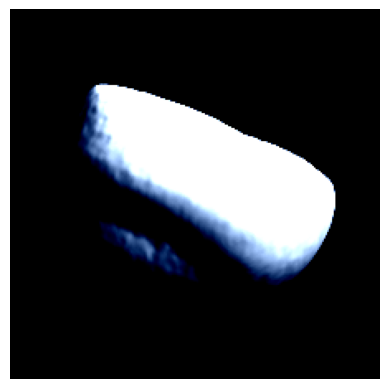

In [104]:
# plot the left image
import matplotlib.pyplot as plt

plt.imshow(imgs[8].permute(1,2,0).cpu().numpy(), cmap='gray')
plt.axis('off')
plt.show()

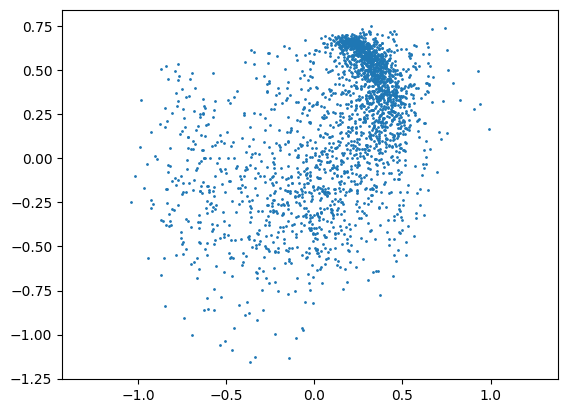

In [105]:
import matplotlib.pyplot as plt
verts = out["pred_coord"][2][0]        # select level‐2, batch‐0
verts = verts.detach().cpu().numpy()        # to numpy

# project to XY plane for a scatterplot
plt.scatter(verts[:,0], verts[:,1], s=1)
plt.axis('equal')
plt.show()

In [11]:
import trimesh

stage = 2

# 1) grab the predicted fine‐mesh coords (B, V3, 3)
verts = out["pred_coord"][stage][0]        # select level‐2, batch‐0
verts = verts.detach().cpu().numpy()        # to numpy

print(verts.shape)

# 2) grab the faces for the fine mesh
faces = ell.faces[stage].cpu().numpy()         # (F3, 3)
print(faces.shape)

# 3) build & show the Trimesh
mesh = trimesh.Trimesh(vertices=verts, faces=faces)
mesh.show()   # this will pop up your system viewer (or inline in notebook)


(2562, 3)
(5120, 3)


c:\Users\fahrn\Documents\Classes\bat\sequoia\.venv\Lib\site-packages\pyglet\libs\win32\__init__.py:318: UserWarning: Could not set COM MTA mode. Unexpected behavior may occur.
  warnings.warn("Could not set COM MTA mode. Unexpected behavior may occur.")
